In [12]:
import math

import numpy as np
import tensorflow as tf
from Dive_into_deep_learning.d2l import tensorflow as d2l

In [7]:
class RNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        """
        :param num_inputs: num of unique tokens
        :param num_hiddens: 
        :param sigma: 
        """
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = tf.Variable(tf.random.normal((num_inputs, num_hiddens)) * sigma)
        self.W_hh = tf.Variable(tf.random.normal((num_hiddens, num_hiddens)) * sigma)
        self.b_h = tf.Variable(tf.zeros(num_hiddens))

    def forward(self, inputs, state=None):
        if state is None:
            # Initial state with shape: (batch_size, nun_hiddens)
            state = tf.zeros((inputs.shape[1], self.num_hiddens))
        else:
            state, = state
            state = tf.reshape(state, (-1, self.num_hiddens))
        outputs = []
        for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
            state = tf.tanh(tf.matmul(X, self.W_xh) + tf.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state

batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = tf.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

outputs保留了所有的state，而state变量保留的是最后一个state

In [13]:
np.all((outputs[-1] == state).numpy())

True

In [3]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
        f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

## RNN-based Language Model

In [4]:
class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""

    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = tf.Variable(tf.random.normal(
            (self.rnn.num_hiddens, self.vocab_size)) * self.rnn.sigma)
        self.b_q = tf.Variable(tf.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', tf.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', tf.exp(l), train=False)

    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return tf.one_hot(tf.transpose(X), self.vocab_size)
    
    def output_layer(self, rnn_outputs):
        outputs = [tf.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return tf.stack(outputs, 1)
    
    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)

In [5]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(tf.ones((batch_size, num_steps), dtype=tf.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

In [6]:
@d2l.add_to_class(d2l.Trainer)
def clip_gradient(self, grad_clip_val, grads):
    grad_clip_val = tf.constant(grad_clip_val, dtype=tf.float32)
    new_grads = [tf.convert_to_tensor(grad) if isinstance(grad, tf.IndexedSlices) else grad for grad in grads]
    norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)) for grad in new_grads))
    if tf.greater(norm, grad_clip_val):
        for i, grad in enumerate(new_grads):
            new_grads[i] = grad * grad_clip_val / norm
        return new_grads
    return grads

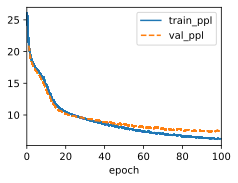

In [7]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
with d2l.try_gpu():
    rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
    model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1)
trainer.fit(model, data)

In [8]:
@d2l.add_to_class(RNNLMScratch)  #@save
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = tf.constant([[outputs[-1]]])
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(tf.reshape(tf.argmax(Y, axis=2), 1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [9]:
model.predict('it has', 20, data.vocab)

'it has gath the pait the t'